## Libraries

Do not import any additional libraries

In [ ]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F

## Download dataset and create a data loader
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this assignment, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO, MNIST ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the CIFAR10 dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#download test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Model without Dropout ('w/o Dropout')
# Define a CNN model with following layers: input > Conv > Pool > Conv > Pool > Linear > Output
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# Model with Dropout ('w/ Dropout')
# Define a CNN model with following layers: input > Conv > Pool > Conv > Pool > Linear > Output
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32*8*8,512)
        self.dropout2 = nn.Dropout(0.50)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc2(x), 1)
        return x

model2 = CNN2().to(device)
print(model2)

CNN2(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
#negative log likelihood loss
loss_fn = nn.NLLLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters())
optimizer2 = torch.optim.Adam(model2.parameters())


## Training function

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

## Testing function

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

## Training process

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
epochs = 20
all_train_accuracies = []
all_test_accuracies = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    all_train_accuracies += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model, loss_fn)
    all_test_accuracies += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

  5%|▌         | 1/20 [00:22<07:02, 22.26s/it]

Epoch 1:	 Train accuracy: 51.0%	 Avg train loss: 1.360281	 Test accuracy: 60.2%	 Avg test loss: 1.116500


 10%|█         | 2/20 [00:37<05:27, 18.17s/it]

Epoch 2:	 Train accuracy: 65.0%	 Avg train loss: 0.982640	 Test accuracy: 66.8%	 Avg test loss: 0.942777


 15%|█▌        | 3/20 [00:53<04:49, 17.01s/it]

Epoch 3:	 Train accuracy: 71.8%	 Avg train loss: 0.800541	 Test accuracy: 69.6%	 Avg test loss: 0.883095


 20%|██        | 4/20 [01:09<04:30, 16.88s/it]

Epoch 4:	 Train accuracy: 77.3%	 Avg train loss: 0.650224	 Test accuracy: 69.6%	 Avg test loss: 0.924521


 25%|██▌       | 5/20 [01:26<04:09, 16.66s/it]

Epoch 5:	 Train accuracy: 82.2%	 Avg train loss: 0.507807	 Test accuracy: 71.4%	 Avg test loss: 0.899722


 30%|███       | 6/20 [01:41<03:48, 16.32s/it]

Epoch 6:	 Train accuracy: 86.8%	 Avg train loss: 0.380652	 Test accuracy: 70.5%	 Avg test loss: 0.971765


 35%|███▌      | 7/20 [01:57<03:29, 16.14s/it]

Epoch 7:	 Train accuracy: 90.9%	 Avg train loss: 0.263041	 Test accuracy: 71.1%	 Avg test loss: 1.084560


 40%|████      | 8/20 [02:13<03:13, 16.09s/it]

Epoch 8:	 Train accuracy: 94.0%	 Avg train loss: 0.176015	 Test accuracy: 70.8%	 Avg test loss: 1.282458


 45%|████▌     | 9/20 [02:29<02:56, 16.01s/it]

Epoch 9:	 Train accuracy: 95.6%	 Avg train loss: 0.128063	 Test accuracy: 70.1%	 Avg test loss: 1.375496


 50%|█████     | 10/20 [02:44<02:38, 15.88s/it]

Epoch 10:	 Train accuracy: 96.3%	 Avg train loss: 0.106672	 Test accuracy: 70.8%	 Avg test loss: 1.516659


 55%|█████▌    | 11/20 [03:00<02:22, 15.86s/it]

Epoch 11:	 Train accuracy: 96.9%	 Avg train loss: 0.092114	 Test accuracy: 70.7%	 Avg test loss: 1.617824


 60%|██████    | 12/20 [03:17<02:07, 15.97s/it]

Epoch 12:	 Train accuracy: 97.3%	 Avg train loss: 0.081175	 Test accuracy: 69.1%	 Avg test loss: 1.850787


 65%|██████▌   | 13/20 [03:32<01:50, 15.85s/it]

Epoch 13:	 Train accuracy: 97.2%	 Avg train loss: 0.082612	 Test accuracy: 69.2%	 Avg test loss: 1.890078


 70%|███████   | 14/20 [03:47<01:34, 15.70s/it]

Epoch 14:	 Train accuracy: 97.7%	 Avg train loss: 0.067094	 Test accuracy: 70.0%	 Avg test loss: 1.896622


 75%|███████▌  | 15/20 [04:03<01:17, 15.57s/it]

Epoch 15:	 Train accuracy: 97.7%	 Avg train loss: 0.069275	 Test accuracy: 69.9%	 Avg test loss: 2.080536


 80%|████████  | 16/20 [04:19<01:03, 15.79s/it]

Epoch 16:	 Train accuracy: 97.8%	 Avg train loss: 0.064763	 Test accuracy: 69.6%	 Avg test loss: 2.230712


 85%|████████▌ | 17/20 [04:34<00:46, 15.63s/it]

Epoch 17:	 Train accuracy: 98.1%	 Avg train loss: 0.053925	 Test accuracy: 69.7%	 Avg test loss: 2.196899


 90%|█████████ | 18/20 [04:50<00:31, 15.52s/it]

Epoch 18:	 Train accuracy: 98.1%	 Avg train loss: 0.056602	 Test accuracy: 70.3%	 Avg test loss: 2.236222


 95%|█████████▌| 19/20 [05:05<00:15, 15.46s/it]

Epoch 19:	 Train accuracy: 98.0%	 Avg train loss: 0.059336	 Test accuracy: 70.1%	 Avg test loss: 2.285473


100%|██████████| 20/20 [05:21<00:00, 16.08s/it]

Epoch 20:	 Train accuracy: 98.1%	 Avg train loss: 0.058489	 Test accuracy: 68.6%	 Avg test loss: 2.575062


In [ ]:
epochs = 20
all_train_accuracies_2 = []
all_test_accuracies_2 = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model2, loss_fn, optimizer2)
    all_train_accuracies_2 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model2, loss_fn)
    all_test_accuracies_2 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

  5%|▌         | 1/20 [00:15<05:02, 15.90s/it]

Epoch 1:	 Train accuracy: 45.8%	 Avg train loss: 1.495151	 Test accuracy: 58.1%	 Avg test loss: 1.192961


 10%|█         | 2/20 [00:31<04:41, 15.61s/it]

Epoch 2:	 Train accuracy: 57.7%	 Avg train loss: 1.183547	 Test accuracy: 63.6%	 Avg test loss: 1.035815


 15%|█▌        | 3/20 [00:47<04:26, 15.66s/it]

Epoch 3:	 Train accuracy: 62.4%	 Avg train loss: 1.062015	 Test accuracy: 66.8%	 Avg test loss: 0.956204


 20%|██        | 4/20 [01:03<04:13, 15.82s/it]

Epoch 4:	 Train accuracy: 65.3%	 Avg train loss: 0.983902	 Test accuracy: 69.8%	 Avg test loss: 0.870641


 25%|██▌       | 5/20 [01:18<03:56, 15.74s/it]

Epoch 5:	 Train accuracy: 67.5%	 Avg train loss: 0.926882	 Test accuracy: 70.7%	 Avg test loss: 0.844681


 30%|███       | 6/20 [01:34<03:39, 15.68s/it]

Epoch 6:	 Train accuracy: 69.0%	 Avg train loss: 0.874244	 Test accuracy: 71.7%	 Avg test loss: 0.822817


 35%|███▌      | 7/20 [01:49<03:23, 15.64s/it]

Epoch 7:	 Train accuracy: 70.4%	 Avg train loss: 0.841160	 Test accuracy: 72.3%	 Avg test loss: 0.799784


 40%|████      | 8/20 [02:05<03:09, 15.78s/it]

Epoch 8:	 Train accuracy: 71.1%	 Avg train loss: 0.811611	 Test accuracy: 72.5%	 Avg test loss: 0.794204


 45%|████▌     | 9/20 [02:21<02:53, 15.74s/it]

Epoch 9:	 Train accuracy: 72.3%	 Avg train loss: 0.783038	 Test accuracy: 73.2%	 Avg test loss: 0.776271


 50%|█████     | 10/20 [02:37<02:37, 15.71s/it]

Epoch 10:	 Train accuracy: 73.0%	 Avg train loss: 0.767634	 Test accuracy: 73.9%	 Avg test loss: 0.760664


 55%|█████▌    | 11/20 [02:52<02:21, 15.67s/it]

Epoch 11:	 Train accuracy: 74.1%	 Avg train loss: 0.738245	 Test accuracy: 73.6%	 Avg test loss: 0.776220


 60%|██████    | 12/20 [03:09<02:06, 15.87s/it]

Epoch 12:	 Train accuracy: 74.2%	 Avg train loss: 0.726198	 Test accuracy: 74.1%	 Avg test loss: 0.751161


 65%|██████▌   | 13/20 [03:24<01:50, 15.76s/it]

Epoch 13:	 Train accuracy: 75.2%	 Avg train loss: 0.705155	 Test accuracy: 75.1%	 Avg test loss: 0.729091


 70%|███████   | 14/20 [03:40<01:34, 15.69s/it]

Epoch 14:	 Train accuracy: 75.5%	 Avg train loss: 0.689486	 Test accuracy: 74.0%	 Avg test loss: 0.767170


 75%|███████▌  | 15/20 [03:55<01:18, 15.69s/it]

Epoch 15:	 Train accuracy: 76.1%	 Avg train loss: 0.669329	 Test accuracy: 75.0%	 Avg test loss: 0.730730


 80%|████████  | 16/20 [04:12<01:03, 15.95s/it]

Epoch 16:	 Train accuracy: 76.3%	 Avg train loss: 0.669196	 Test accuracy: 74.3%	 Avg test loss: 0.741406


 85%|████████▌ | 17/20 [04:27<00:47, 15.78s/it]

Epoch 17:	 Train accuracy: 77.1%	 Avg train loss: 0.645832	 Test accuracy: 75.0%	 Avg test loss: 0.739579


 90%|█████████ | 18/20 [04:43<00:31, 15.73s/it]

Epoch 18:	 Train accuracy: 77.4%	 Avg train loss: 0.636227	 Test accuracy: 75.0%	 Avg test loss: 0.736876


 95%|█████████▌| 19/20 [04:58<00:15, 15.63s/it]

Epoch 19:	 Train accuracy: 77.8%	 Avg train loss: 0.625081	 Test accuracy: 75.3%	 Avg test loss: 0.733793


100%|██████████| 20/20 [05:15<00:00, 15.76s/it]

Epoch 20:	 Train accuracy: 78.0%	 Avg train loss: 0.617007	 Test accuracy: 75.0%	 Avg test loss: 0.742591


## Plot Results

Display the training and testing accuracy as a function of the number of epochs



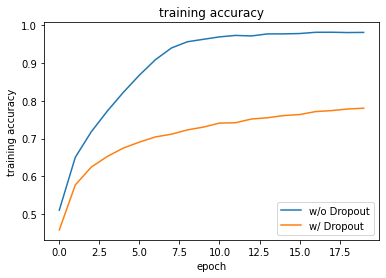

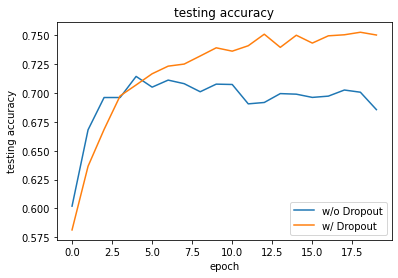

In [ ]:
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['w/o Dropout','w/ Dropout'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_2)

plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['w/o Dropout','w/ Dropout'], loc='lower right')
plt.show()


Explanation:

* As we can see from the training and testing accuracy plots, model trained with dropout is able to provide much higher test accuracy level compared to model trained without dropout, when the models are trained for sufficient number of epochs.
* It is interesting to note that in the without dropout model case we get comparatively very higher train accuracy level as model becomes more expressive with more active neurons and weights. However, it is overfitting on the train data, as it is unable to generalize on the test data and as a result we get much lower test accuracy for this model compared to the model trained with dropout.
* Dropout randomly switches off some of the neurons in the selected layers randomly while training the model, so this makes model training little slower as less number of neurons are available in each epoch during backpropagation of loss, but this helps model to avoid learning some noise in the data, and this makes model more robust for the test data.
* And therefore we must also note here that, if we are using dropout in our model training, then we will need higher number of epochs to learn the right parameters (weights and biases) values before we start getting comparatively higher test accuracy levels than the without dropout based trained model. Here we are getting highest test accuracy level after around 19 epochs when the model is trained with dropout.